<a href="https://colab.research.google.com/github/acb-code/data-science-learning/blob/main/mnist_classifier_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# https://github.com/NVDLI/LDL/blob/main/pt_framework/c5e1_mnist_learning.ipynb
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import numpy as np
torch.manual_seed(7)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
EPOCHS = 20
BATCH_SIZE = 1

In [2]:
# load training dataset into single batch to compute mean and std
transform = transforms.Compose([transforms.ToTensor()])
trainset = MNIST(root='./pt_data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=len(trainset), shuffle=True)
data = next(iter(trainloader))
mean = data[0].mean()
std = data[0].std()
print(mean, std)

100%|██████████| 9.91M/9.91M [00:00<00:00, 23.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 558kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.43MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.69MB/s]


tensor(0.1307) tensor(0.3081)


In [3]:
# get the normalized training and test sets
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean, std)])

trainset = MNIST(root='./pt_data', train=True, download=True, transform=transform)
testset = MNIST(root='./pt_data', train=False, download=True, transform=transform)


In [4]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 25),
    nn.Tanh(),
    nn.Linear(25, 10),
    nn.Sigmoid()
)

# initialize weights
for module in model.modules():
  if isinstance(module, nn.Linear):
    nn.init.uniform_(module.weight, a=-0.1, b=0.1)
    nn.init.constant_(module.bias, 0.0)

In [5]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
loss_function = nn.MSELoss()

model.to(device)

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True)

for i in range(EPOCHS):
  model.train()
  train_loss = 0.0
  train_correct = 0
  train_batches = 0
  for inputs, targets in trainloader:
    # move data to GPU
    one_hot_targets = nn.functional.one_hot(targets, num_classes=10).float()
    inputs, targets, one_hot_targets = inputs.to(device), targets.to(device), one_hot_targets.to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = loss_function(outputs, one_hot_targets)

    _, indices = torch.max(outputs, 1)
    train_correct += (indices == targets).sum().item()
    train_batches += 1
    train_loss += loss.item()

    loss.backward()
    optimizer.step()
  train_loss = train_loss / train_batches
  train_acc = train_correct / (train_batches * BATCH_SIZE)

  # eval model
  model.eval()
  test_loss = 0.0
  test_correct = 0
  test_batches = 0
  for inputs, targets in testloader:
    one_hot_targets = nn.functional.one_hot(targets, num_classes=10).float()
    inputs, targets, one_hot_targets = inputs.to(device), targets.to(device), one_hot_targets.to(device)
    outputs = model(inputs)
    loss = loss_function(outputs, one_hot_targets)
    _, indices = torch.max(outputs, 1)
    test_correct += (indices == targets).sum().item()
    test_batches += 1
    test_loss += loss.item()

  test_loss = test_loss / test_batches
  test_acc = test_correct / (test_batches * BATCH_SIZE)

  print(f'Epoch {i+1}/{EPOCHS} loss: {train_loss:.4f} - acc: {train_acc:0.4f} - val_loss: {test_loss:.4f} - val_acc: {test_acc:0.4f}')

Epoch 1/20 loss: 0.0501 - acc: 0.7087 - val_loss: 0.0238 - val_acc: 0.8955
Epoch 2/20 loss: 0.0198 - acc: 0.9038 - val_loss: 0.0163 - val_acc: 0.9153
Epoch 3/20 loss: 0.0156 - acc: 0.9167 - val_loss: 0.0140 - val_acc: 0.9245
Epoch 4/20 loss: 0.0140 - acc: 0.9225 - val_loss: 0.0129 - val_acc: 0.9276
Epoch 5/20 loss: 0.0129 - acc: 0.9281 - val_loss: 0.0126 - val_acc: 0.9282
Epoch 6/20 loss: 0.0122 - acc: 0.9312 - val_loss: 0.0118 - val_acc: 0.9325
Epoch 7/20 loss: 0.0116 - acc: 0.9347 - val_loss: 0.0115 - val_acc: 0.9331
Epoch 8/20 loss: 0.0112 - acc: 0.9368 - val_loss: 0.0111 - val_acc: 0.9360
Epoch 9/20 loss: 0.0108 - acc: 0.9393 - val_loss: 0.0109 - val_acc: 0.9352
Epoch 10/20 loss: 0.0104 - acc: 0.9416 - val_loss: 0.0106 - val_acc: 0.9372
Epoch 11/20 loss: 0.0102 - acc: 0.9423 - val_loss: 0.0104 - val_acc: 0.9398
Epoch 12/20 loss: 0.0098 - acc: 0.9451 - val_loss: 0.0102 - val_acc: 0.9393
Epoch 13/20 loss: 0.0096 - acc: 0.9458 - val_loss: 0.0101 - val_acc: 0.9415
Epoch 14/20 loss: 0.0

ValueError: x and y must have same first dimension, but have shapes (20,) and (1,)

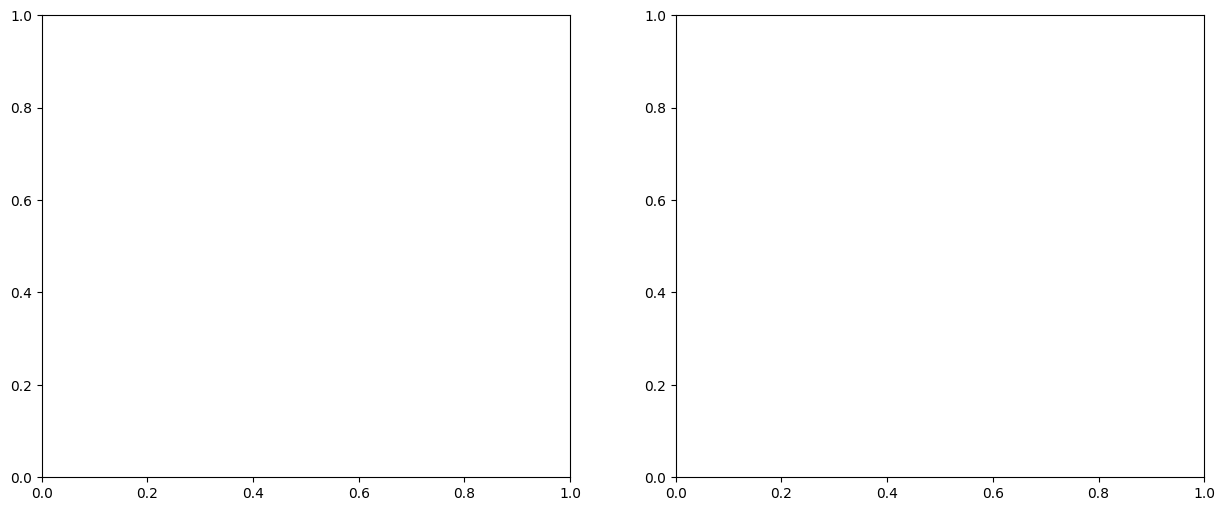

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 6))
ax = ax.ravel()

ax[0].plot(range(EPOCHS), train_loss)

In [6]:
print(train_loss)

0.008391492390549699
